In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import imghdr
import matplotlib.pyplot as plt
import pathlib

c:\Users\abeme\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# After scrapper is ran, file plant will be the path of all the images
data_dir = pathlib.Path("plant")
data_dir


WindowsPath('plant')

### Remove unreadable file

In [3]:
# Image extensions
image_exts=  ["jpeg", "jpg", "bmp", "png"]

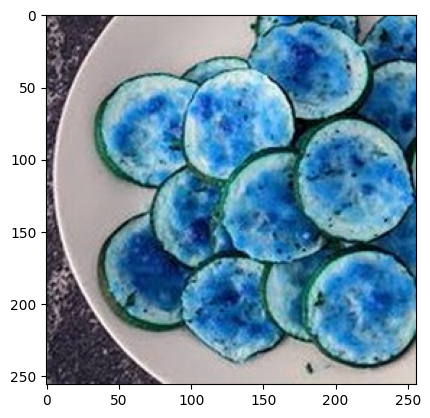

In [4]:
# Going through all the images and removing images that are not right extensions
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        # The full image path
        
        try:
            img = cv2.imread(image_path)
            plt.imshow(img)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Removing image : Wrong extension")
                os.remove(image_path)
        except Exception as e:
            print(f"Issue with image {image_path}")
            print(e)

### Resize the pictures

In [5]:
# Go through all the pictures and resize and save the image
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        # Image path
        
        if os.path.isfile(image_path):
            im = PIL.Image.open(image_path)
            f, e = os.path.splitext(image_path)
            imResize = im.resize((256,256), PIL.Image.ANTIALIAS)
            if imResize.mode != 'RGB':
                print(f"Converting {image_path} into RGB")
                imResize = imResize.convert('RGB')
            imResize.save(f + '.jpeg', 'JPEG', quality=90)


C:\Users\abeme\AppData\Local\Temp\ipykernel_29428\3354532628.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imResize = im.resize((256,256), PIL.Image.ANTIALIAS)


In [6]:
# Clean up the data

In [7]:
batch_size = 32
img_height = 256
img_width = 256

In [8]:
# Split the data into 32 batchs and split down into training dataset and validation dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed = 1,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed = 1,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3531 files belonging to 10 classes.
Using 2825 files for training.
Found 3531 files belonging to 10 classes.
Using 706 files for validation.


In [9]:
# Get class name of each data category
class_names = train_ds.class_names
print(class_names)

['bell pepper', 'carrots', 'cauliflower', 'cucumber', 'lettuce', 'onions', 'potato', 'pumpkin', 'tomato', 'zucchini']


In [10]:
# Change the values from 0-255 to 0-1
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
# Normalize the entire dataset
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
# Configure the model through multiple Rescaling and Flatting

num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [13]:
# Run the model using adam optimizer 
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [14]:
# Track the number of parameter
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        3

In [15]:
# Train and fit the model

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
89/89 [==============================] - 99s 1s/step - loss: 1.6692 - accuracy: 0.3646 - val_loss: 1.4537 - val_accuracy: 0.4462
Epoch 2/10
89/89 [==============================] - 101s 1s/step - loss: 1.3399 - accuracy: 0.4913 - val_loss: 1.2858 - val_accuracy: 0.5255
Epoch 3/10
89/89 [==============================] - 101s 1s/step - loss: 1.2281 - accuracy: 0.5388 - val_loss: 1.3242 - val_accuracy: 0.5000
Epoch 4/10
89/89 [==============================] - 113s 1s/step - loss: 1.0661 - accuracy: 0.6088 - val_loss: 1.2756 - val_accuracy: 0.5071
Epoch 5/10
89/89 [==============================] - 110s 1s/step - loss: 0.8151 - accuracy: 0.7051 - val_loss: 1.4731 - val_accuracy: 0.4972
Epoch 6/10
89/89 [==============================] - 108s 1s/step - loss: 0.5040 - accuracy: 0.8237 - val_loss: 1.7290 - val_accuracy: 0.4674
Epoch 7/10
89/89 [==============================] - 105s 1s/step - loss: 0.2587 - accuracy: 0.9133 - val_loss: 2.0126 - val_accuracy: 0.4915
Epoch 8/10
89/

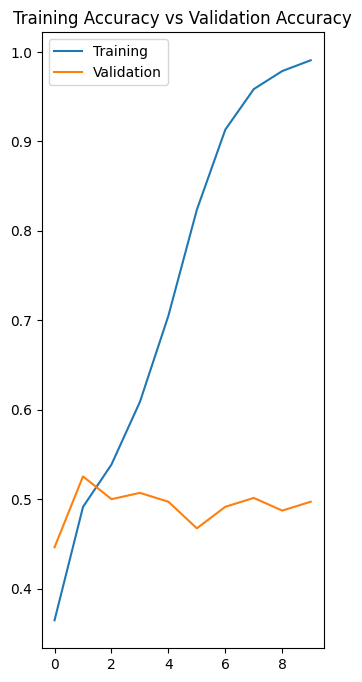

In [17]:
# Plot the accuracy for the model at different epoch's
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")
plt.show()
